In [181]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
from statsmodels.stats.diagnostic import het_breuschpagan, linear_reset
from sklearn.model_selection import KFold

In [182]:
MASTER = Path("../data/processed/master_teams_2000_2019.csv")
TAB_OUT = Path("../data/processed")
FIG_OUT = Path("../plots")
LATEX_OUT = Path("../latex/tables")
for p in (TAB_OUT, FIG_OUT, LATEX_OUT):
    p.mkdir(parents=True, exist_ok=True)

In [183]:
def kfold_rmse(y, X, n_splits=10, random_state=42):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    rmses = []
    for tr, te in kf.split(X):
        Xtr, Xte = X[tr, :], X[te, :]
        ytr, yte = y[tr], y[te]
        model = sm.OLS(ytr, Xtr).fit()
        yhat = model.predict(Xte)
        rmse = np.sqrt(np.mean((yte - yhat) ** 2))
        rmses.append(rmse)
    return float(np.mean(rmses)), float(np.std(rmses))

In [184]:
def fit_and_summarize(df, y_col, X_cols, name):
    sub = df[[y_col] + X_cols].dropna().copy()

    X = add_constant(sub[X_cols], has_constant="add")
    y = sub[y_col]

    model = sm.OLS(y, X).fit()

    yhat = model.predict(X)
    resid = y - yhat
    rmse = float(np.sqrt(np.mean(resid**2)))
    mae = float(np.mean(np.abs(resid)))

    X_np = X.to_numpy()
    y_np = y.to_numpy()
    splits = max(2, min(10, len(y_np)))
    rmse_cv_mean, rmse_cv_sd = kfold_rmse(y_np, X_np, n_splits=splits, random_state=42)

    bp_lm, bp_lm_p, bp_f, bp_f_p = het_breuschpagan(resid, X)

    reset = linear_reset(model, power=3, use_f=True)
    reset_f = float(reset.fvalue)
    reset_p = float(reset.pvalue)

    res = {
        "modelo": name,
        "k": int(X.shape[1] - 1),
        "AIC": float(model.aic),
        "BIC": float(model.bic),
        "R2": float(model.rsquared),
        "R2_adj": float(model.rsquared_adj),
        "RMSE": rmse,
        "MAE": mae,
        "RMSE_CV_mean": rmse_cv_mean,
        "RMSE_CV_sd": rmse_cv_sd,
        "BP_F": float(bp_f),
        "BP_p": float(bp_f_p),
        "RESET_F": reset_f,
        "RESET_p": reset_p,
        "N": int(model.nobs),
        "coef": model.params.to_dict(),
        "pvalues": model.pvalues.to_dict(),
    }
    return res, sub, model, yhat.to_numpy(), resid.to_numpy()

In [185]:
df = pd.read_csv(MASTER, parse_dates=["season_date"])

In [186]:
if "logHR1" not in df.columns:
    df["logHR1"] = np.log(df["HR"] + 1)

df["ERA2"] = df["ERA"] ** 2
df["RunDiff2"] = df["RunDiff"] ** 2

In [187]:
res_HR_lin, sub_HR_lin, mod_HR_lin, yhat_HR_lin, resid_HR_lin = fit_and_summarize(
    df, "W", ["HR"], "W ~ HR"
)
res_HR_log, sub_HR_log, mod_HR_log, yhat_HR_log, resid_HR_log = fit_and_summarize(
    df, "W", ["logHR1"], "W ~ log(HR+1)"
)

res_ERA_lin, sub_ERA_lin, mod_ERA_lin, yhat_ERA_lin, resid_ERA_lin = fit_and_summarize(
    df, "W", ["ERA"], "W ~ ERA"
)
res_ERA_q, sub_ERA_q, mod_ERA_q, yhat_ERA_q, resid_ERA_q = fit_and_summarize(
    df, "W", ["ERA", "ERA2"], "W ~ ERA + ERA^2"
)

res_RD_lin, sub_RD_lin, mod_RD_lin, yhat_RD_lin, resid_RD_lin = fit_and_summarize(
    df, "W", ["RunDiff"], "W ~ RunDiff"
)
res_RD_q, sub_RD_q, mod_RD_q, yhat_RD_q, resid_RD_q = fit_and_summarize(
    df, "W", ["RunDiff", "RunDiff2"], "W ~ RunDiff + RunDiff^2"
)

In [188]:
rows = [res_HR_lin, res_HR_log, res_ERA_lin, res_ERA_q, res_RD_lin, res_RD_q]
comp = pd.DataFrame(rows)[
    [
        "modelo",
        "k",
        "R2",
        "R2_adj",
        "AIC",
        "BIC",
        "RMSE",
        "MAE",
        "RMSE_CV_mean",
        "RMSE_CV_sd",
        "BP_F",
        "BP_p",
        "RESET_F",
        "RESET_p",
        "N",
    ]
]
comp.to_csv(
    TAB_OUT / "formas_funcionales_summary.csv", index=False, float_format="%.6f"
)

In [1]:
# try:
#     with open(LATEX_OUT / "formas_funcionales_summary.tex", "w") as f:
#         f.write(
#             comp.rename(
#                 columns={
#                     "modelo": "Modelo",
#                     "k": "$k$",
#                     "R2": "$R^2$",
#                     "R2_adj": "$R^2_{adj}$",
#                     "AIC": "AIC",
#                     "BIC": "BIC",
#                     "RMSE": "RMSE",
#                     "MAE": "MAE",
#                     "RMSE_CV_mean": "RMSE$_{CV}$ (media)",
#                     "RMSE_CV_sd": "RMSE$_{CV}$ (sd)",
#                     "BP_F": "BP F",
#                     "$BP_p$": "$p$(BP)",
#                     "BP_p": "$p$(BP)",
#                     "RESET_F": "RESET F",
#                     "RESET_p": "$p$(RESET)",
#                     "N": "N",
#                 }
#             ).to_latex(
#                 index=False,
#                 float_format="%.4f",
#                 caption="Comparación de formas funcionales por predictor",
#                 label="tab:formas_funcionales",
#             )
#         )
#     print("Tabla LaTeX exportada: latex/utils/tables/formas_funcionales_summary.tex")
# except Exception as e:
#     print("No se exportó LaTeX (opcional). Razón:", e)

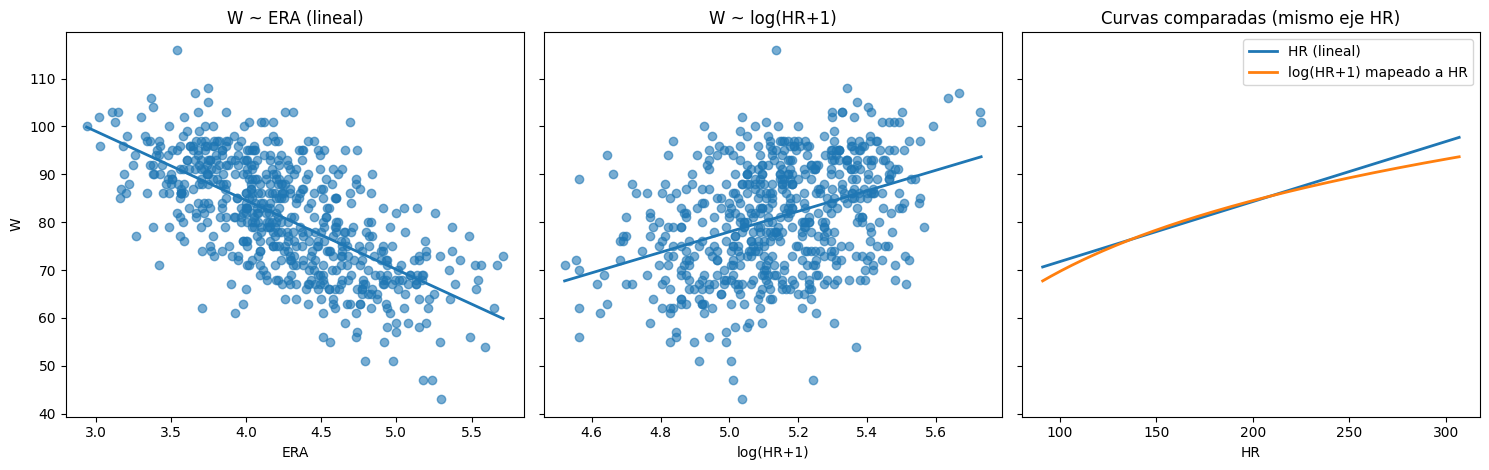

In [190]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4.8), sharey=True)

ax = axes[0]
x_era = sub_ERA_lin["ERA"].to_numpy()
y_era = sub_ERA_lin["W"].to_numpy()
b0_era, b1_era = mod_ERA_lin.params["const"], mod_ERA_lin.params["ERA"]
xs_era = np.linspace(x_era.min(), x_era.max(), 200)
ys_era = b0_era + b1_era * xs_era
ax.scatter(x_era, y_era, alpha=0.6)
ax.plot(xs_era, ys_era, lw=2)
ax.set_title("W ~ ERA (lineal)")
ax.set_xlabel("ERA")
axes[0].set_ylabel("W")

ax = axes[1]
x_log = sub_HR_log["logHR1"].to_numpy()
y_log = sub_HR_log["W"].to_numpy()
b0_log, b1_log = mod_HR_log.params["const"], mod_HR_log.params["logHR1"]
xs_log = np.linspace(x_log.min(), x_log.max(), 200)
ys_log = b0_log + b1_log * xs_log
ax.scatter(x_log, y_log, alpha=0.6)
ax.plot(xs_log, ys_log, lw=2)
ax.set_title("W ~ log(HR+1)")
ax.set_xlabel("log(HR+1)")

ax = axes[2]
x_hr = sub_HR_lin["HR"].to_numpy()
b0_hr, b1_hr = mod_HR_lin.params["const"], mod_HR_lin.params["HR"]
xs_hr = np.linspace(x_hr.min(), x_hr.max(), 200)

ys_hr_lineal = b0_hr + b1_hr * xs_hr
ys_hr_log = b0_log + b1_log * np.log(xs_hr + 1)

ax.plot(xs_hr, ys_hr_lineal, lw=2, label="HR (lineal)")
ax.plot(xs_hr, ys_hr_log, lw=2, label="log(HR+1) mapeado a HR")
ax.set_title("Curvas comparadas (mismo eje HR)")
ax.set_xlabel("HR")
ax.legend()

fig.tight_layout()
fig.savefig(
    FIG_OUT / "formas_funcionales_HR.png",
    dpi=150,
    bbox_inches="tight",
    transparent=True,
)
plt.show()
plt.close(fig)

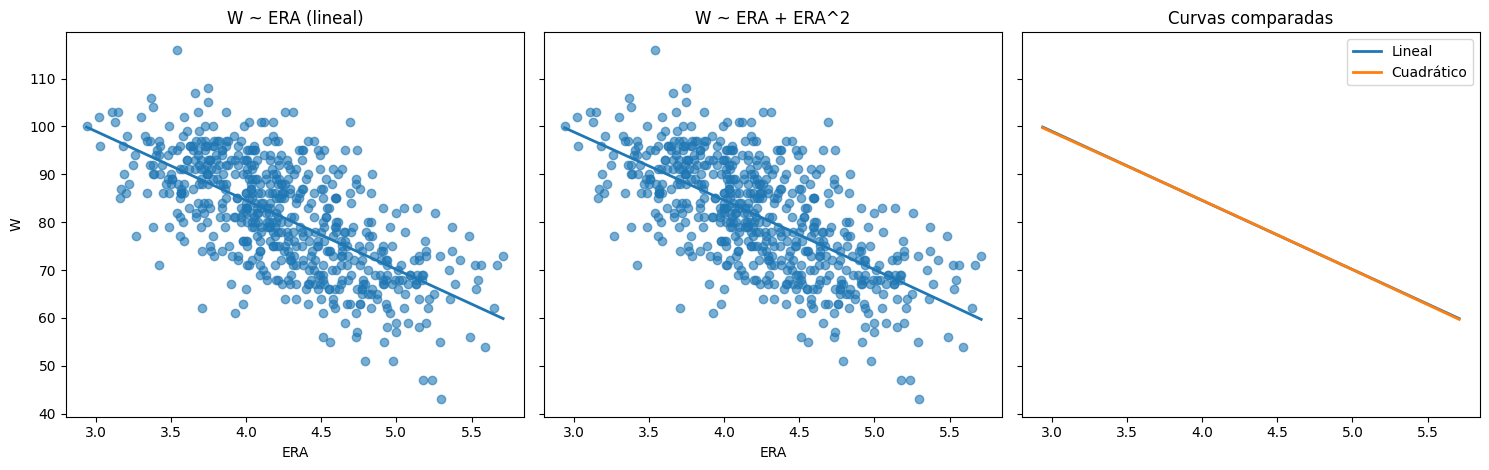

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4.8), sharey=True)

ax = axes[0]
x_lin_era = sub_ERA_lin["ERA"].to_numpy()
y_lin_era = sub_ERA_lin["W"].to_numpy()
b0_lin_era, b1_lin_era = mod_ERA_lin.params["const"], mod_ERA_lin.params["ERA"]
xs_lin_era = np.linspace(x_lin_era.min(), x_lin_era.max(), 200)
ys_lin_era = b0_lin_era + b1_lin_era * xs_lin_era
ax.scatter(x_lin_era, y_lin_era, alpha=0.6)
ax.plot(xs_lin_era, ys_lin_era, lw=2)
ax.set_title("W ~ ERA (lineal)")
ax.set_xlabel("ERA")
axes[0].set_ylabel("W")

ax = axes[1]
x_q_era = sub_ERA_q["ERA"].to_numpy()
y_q_era = sub_ERA_q["W"].to_numpy()
b0_q = mod_ERA_q.params["const"]
b1_q = mod_ERA_q.params["ERA"]
b2_q = mod_ERA_q.params["ERA2"]
xs_quad_era = np.linspace(x_q_era.min(), x_q_era.max(), 200)
ys_quad_era = b0_q + b1_q * xs_quad_era + b2_q * (xs_quad_era**2)
ax.scatter(x_q_era, y_q_era, alpha=0.6)
ax.plot(xs_quad_era, ys_quad_era, lw=2)
ax.set_title("W ~ ERA + ERA^2")
ax.set_xlabel("ERA")

ax = axes[2]
ax.plot(xs_lin_era, ys_lin_era, label="Lineal", lw=2)
ax.plot(xs_quad_era, ys_quad_era, label="Cuadrático", lw=2)
ax.set_title("Curvas comparadas")
ax.legend()

fig.tight_layout()
fig.savefig(
    FIG_OUT / "formas_funcionales_ERA.png",
    dpi=150,
    bbox_inches="tight",
    transparent=True,
)
plt.show()
plt.close(fig)

In [192]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4.8), sharey=True)

ax = axes[0]
x_lin_rd = sub_RD_lin["RunDiff"].to_numpy()
y_lin_rd = sub_RD_lin["W"].to_numpy()
b0_lin_rd, b1_lin_rd = mod_RD_lin.params["const"], mod_RD_lin.params["RunDiff"]
xs_lin_rd = np.linspace(x_lin_rd.min(), x_lin_rd.max(), 200)
ys_lin_rd = b0_lin_rd + b1_lin_rd * xs_lin_rd
ax.scatter(x_lin_rd, y_lin_rd, alpha=0.6)
ax.plot(xs_lin_rd, ys_lin_rd, lw=2)
ax.set_title("W ~ RunDiff (lineal)")
ax.set_xlabel("RunDiff")
axes[0].set_ylabel("W")

ax = axes[1]
x_q_rd = sub_RD_q["RunDiff"].to_numpy()
y_q_rd = sub_RD_q["W"].to_numpy()
b0_q_rd = mod_RD_q.params["const"]
b1_q_rd = mod_RD_q.params["RunDiff"]
b2_q_rd = mod_RD_q.params["RunDiff2"]
xs_quad_rd = np.linspace(x_q_rd.min(), x_q_rd.max(), 200)
ys_quad_rd = b0_q_rd + b1_q_rd * xs_quad_rd + b2_q_rd * (xs_quad_rd**2)
ax.scatter(x_q_rd, y_q_rd, alpha=0.6)
ax.plot(xs_quad_rd, ys_quad_rd, lw=2)
ax.set_title("W ~ RunDiff + RunDiff^2")
ax.set_xlabel("RunDiff")

ax = axes[2]
ax.plot(xs_lin_rd, ys_lin_rd, label="Lineal", lw=2)
ax.plot(xs_quad_rd, ys_quad_rd, label="Cuadrático", lw=2)
ax.set_title("Curvas comparadas")
ax.legend()

fig.tight_layout()
fig.savefig(
    FIG_OUT / "formas_funcionales_RunDiff.png",
    dpi=150,
    bbox_inches="tight",
    transparent=True,
)
plt.close(fig)